In [1]:
import pandas as pd
import numpy as np
import math
import datetime
import json
import requests
import re
import itertools
import re
import ast
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
import collections as co

import time
from datetime import timedelta
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
%matplotlib inline


#for visualisation
%pylab inline
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
sns.set(style="white", color_codes=True)

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)



Populating the interactive namespace from numpy and matplotlib


//anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
want_days_back = 30

In [4]:
#calc K trend line coef
def trendline(data, order=1):
    coeffs = np.polyfit(np.arange(data.shape[0]), list(data), order)
    slope = coeffs[-2]
    return round(float(slope) , 4)

In [5]:
from hyperopt import fmin, hp, tpe, STATUS_OK, Trials
import lightgbm as lgb


In [ ]:
pay_aggr_df  = transactions_df[:]

pay_aggr_df['count'] = np.round( np.log2(pay_aggr_df['count'] + 1) , 2)

pay_aggr_df['weekday'] = pay_aggr_df['dt'].dt.weekday

pay_aggr_df = pay_aggr_df[(pay_aggr_df.reason == 'fact')].drop(['reason'],axis = 1)[:]

In [ ]:
#test
pay_aggr_df.to_csv('./data/pay_aggr_df.csv' , index = False)

In [11]:
#test
pay_aggr_df = None
pay_aggr_df = pd.read_csv('./data2/pay_aggr_df.csv')
pay_aggr_df['date'] = pd.to_datetime(pay_aggr_df['date'])


In [12]:
pay_aggr_df.head()

,date,id_place,id_good,count,category_id,weekday
0,2018-12-10,100,347,3.46,0,0
1,2018-12-10,101,347,2.00,0,0
2,2018-12-10,102,347,2.00,0,0
3,2018-12-10,103,347,1.58,0,0
4,2018-12-10,104,347,2.00,0,0


In [15]:
merge_prev_df = pay_aggr_df[['date'  , 'id_place' ,'id_good' ,'category_id','count']][:]


In [16]:
pay_aggr_df = pay_aggr_df[['date'  , 'id_place','id_good' ,'category_id', 'count' , 'weekday']][:]
pay_aggr_df = pay_aggr_df.sort_values(by = ['id_place','category_id','id_good','date'])[:]

In [17]:
#add prev days info 
def add_prev_days(pay_aggr_df = None ,want_days_back = None , merge_prev_df = None):


    prev_columns = []
    pct_change_columns = []
    pct_rename = {}

    

    #get prev dates info
    for d in range(want_days_back):
        #df_outcome['prev_date_' + str(i+1)] = df_outcome.groupby(['payer_id' , 'receiver_id' , 'currency_id']).transaction_date.shift(i+1)
        pay_aggr_df['count_prev_' + str(d+1)] = pay_aggr_df.groupby(['id_place' , 'category_id', 'id_good' ])['count'].shift(d+1)
        #df_outcome.fillna(-1. , inplace = True)


        
        time.sleep(3)

        
        prev_columns.append('count_prev_'+str(d+1))
        pct_change_columns.append('pct_change_'+str(d+1))
        pct_rename['count_prev_'+str(d+1)] = 'pct_change_'+str(d+1)
        
        
        print(d)
    pay_aggr_df.fillna(0 , inplace = True)

    return pay_aggr_df , prev_columns , pct_change_columns , pct_rename


In [18]:
#add stats info
def add_stats_info(pay_aggr_df = None , want_days_back = None , prev_columns = None):

    add_stats_columns = []


    if want_days_back >= 7:
        add_feat_step = 'w'
        prev_cols = prev_columns[:7]

        pay_aggr_df[add_feat_step + '_miss'] = (pay_aggr_df[prev_cols] == 0).sum(axis = 1)
        pay_aggr_df[add_feat_step + '_cnt'] = pay_aggr_df[prev_cols].sum(axis = 1)
        pay_aggr_df[add_feat_step + '_mean'] = pay_aggr_df[prev_cols].mean(axis = 1)
        pay_aggr_df[add_feat_step + '_min'] = pay_aggr_df[prev_cols].min(axis = 1)
        pay_aggr_df[add_feat_step + '_max'] = pay_aggr_df[prev_cols].max(axis = 1)
        add_stats_columns.extend([add_feat_step + '_miss' , add_feat_step + '_cnt' , add_feat_step + '_mean'
                                 ,add_feat_step + '_min' , add_feat_step + '_max'])


    if want_days_back >= 30:
        add_feat_step = 'm'
        prev_cols = prev_columns[:30]

        pay_aggr_df[add_feat_step + '_miss'] = (pay_aggr_df[prev_cols] == 0).sum(axis = 1)
        pay_aggr_df[add_feat_step + '_cnt'] = pay_aggr_df[prev_cols].sum(axis = 1)
        pay_aggr_df[add_feat_step + '_mean'] = pay_aggr_df[prev_cols].mean(axis = 1)
        pay_aggr_df[add_feat_step + '_min'] = pay_aggr_df[prev_cols].min(axis = 1)
        pay_aggr_df[add_feat_step + '_max'] = pay_aggr_df[prev_cols].max(axis = 1)   

        pay_aggr_df[add_feat_step + '_25perc'] = np.percentile(pay_aggr_df[prev_cols] , 25 , axis = 1)
        pay_aggr_df[add_feat_step + '_75perc'] = np.percentile(pay_aggr_df[prev_cols] , 25 , axis = 1)
        pay_aggr_df[add_feat_step + '_std'] = np.std(pay_aggr_df[prev_cols]  , axis = 1)
        add_stats_columns.extend([add_feat_step + '_miss' , add_feat_step + '_cnt' , add_feat_step + '_mean'
                                 ,add_feat_step + '_min' , add_feat_step + '_max'
                                 ,add_feat_step + '_25perc',add_feat_step + '_75perc',add_feat_step + '_std'])


    if want_days_back >= 90:
        add_feat_step = 'q'
        prev_cols = prev_columns[:90]

        pay_aggr_df[add_feat_step + '_miss'] = (pay_aggr_df[prev_cols] == 0).sum(axis = 1)
        pay_aggr_df[add_feat_step + '_cnt'] = pay_aggr_df[prev_cols].sum(axis = 1)
        pay_aggr_df[add_feat_step + '_mean'] = pay_aggr_df[prev_cols].mean(axis = 1)
        pay_aggr_df[add_feat_step + '_min'] = pay_aggr_df[prev_cols].min(axis = 1)
        pay_aggr_df[add_feat_step + '_max'] = pay_aggr_df[prev_cols].max(axis = 1)   

        pay_aggr_df[add_feat_step + '_25perc'] = np.percentile(pay_aggr_df[prev_cols] , 25 , axis = 1)
        pay_aggr_df[add_feat_step + '_75perc'] = np.percentile(pay_aggr_df[prev_cols] , 25 , axis = 1)
        pay_aggr_df[add_feat_step + '_std'] = np.std(pay_aggr_df[prev_cols]  , axis = 1)
        add_stats_columns.extend([add_feat_step + '_miss' , add_feat_step + '_cnt' , add_feat_step + '_mean'
                                 ,add_feat_step + '_min' , add_feat_step + '_max'
                                 ,add_feat_step + '_25perc',add_feat_step + '_75perc',add_feat_step + '_std'])
        
    return pay_aggr_df , add_stats_columns



In [19]:
#add not main features
def add_aditional(pay_aggr_df = None , prev_columns = None , pct_change_columns = None , pct_rename = None):
    prev_cols = prev_columns
    
    pay_aggr_df = pd.merge(pay_aggr_df
                           ,pay_aggr_df[prev_cols].pct_change(periods=1,axis=1, fill_method='ffill').rename(columns=pct_rename)[pct_change_columns[1:]]
                          ,left_index = True
                           ,right_index = True
                          )
    return pay_aggr_df



In [20]:
#clear nulls 
def clear_nulls(pay_aggr_df=None):
    pay_aggr_df.replace([np.inf, -np.inf], np.nan , inplace = True)
    pay_aggr_df.fillna(0 , inplace = True)
    return pay_aggr_df




In [21]:
#make dummies
def make_dummies(pay_aggr_df = None):
    dfDummies = pd.get_dummies(pay_aggr_df['id_place'], prefix = 'id_place')
    pay_aggr_df = pd.concat([pay_aggr_df, dfDummies], axis=1)
    dfDummies = pd.get_dummies(pay_aggr_df['id_good'], prefix = 'id_good')
    pay_aggr_df = pd.concat([pay_aggr_df, dfDummies], axis=1)
    dfDummies = pd.get_dummies(pay_aggr_df['category_id'], prefix = 'category_id')
    pay_aggr_df = pd.concat([pay_aggr_df, dfDummies], axis=1)
    dfDummies = pd.get_dummies(pay_aggr_df['weekday'], prefix = 'weekday')
    pay_aggr_df = pd.concat([pay_aggr_df, dfDummies], axis=1)
    
    return pay_aggr_df



In [22]:
print('add_prev_days')
pay_aggr_df , prev_columns , pct_change_columns , pct_rename = add_prev_days(pay_aggr_df = pay_aggr_df , want_days_back = want_days_back , merge_prev_df = merge_prev_df)
time.sleep(0.1)
print('add_stats_info')
pay_aggr_df , add_stats_columns = add_stats_info(pay_aggr_df = pay_aggr_df , want_days_back = want_days_back , prev_columns = prev_columns)
print('add_aditional')
pay_aggr_df = add_aditional(pay_aggr_df = pay_aggr_df , prev_columns = prev_columns , pct_change_columns = pct_change_columns , pct_rename = pct_rename)
print('clear_nulls')
pay_aggr_df = clear_nulls(pay_aggr_df=pay_aggr_df)
print('make_dummies')
pay_aggr_df = make_dummies(pay_aggr_df = pay_aggr_df)


add_prev_days
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
add_stats_info
add_aditional
clear_nulls
make_dummies


In [23]:
#drop columns
not_interest_columns = ['date' , 'id_place' ,'category_id' ,'id_good' , 'weekday' , 'date_prev'
                       ,'item_discount','discount' , 'amount' , 'cost']


In [24]:
interest_columns = list(set(list(pay_aggr_df.columns)) - set(['count']) - set(not_interest_columns))
target_col = 'count'

In [30]:



best = {'bagging_fraction': 0.9623173298501537
        , 'bagging_freq': 16.0
        , 'boosting_type': 0
        , 'colsample_bytree': 0.9960457339028292
        , 'feature_fraction': 0.9290456045188848
        , 'max_depth': 18.0
        , 'num_leaves': 56.0
        , 'objective': 0}

params = best

params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = {'l2','mse'}


for i in params:
    if type(params[i]) != str and type(params[i]) != set:
        if int(params[i]) == params[i]:
            params[i] = int(params[i])

In [27]:
test_date = '2019-06-01'

In [29]:
#%%time
test_date = '2019-06-01'
X_train = pay_aggr_df[(pay_aggr_df['date'] < test_date)][interest_columns][:]
X_test = pay_aggr_df[(pay_aggr_df['date'] >= test_date)][interest_columns][:]
y_train = pay_aggr_df[(pay_aggr_df['date'] < test_date)][target_col][:]
y_test = pay_aggr_df[(pay_aggr_df['date'] >= test_date)][target_col][:]

#X_train, X_test, y_train, y_test = train_test_split(pay_aggr_df[interest_columns][:], pay_aggr_df[target_col][:]) 

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test)

lgb_tt = lgb.Dataset(pay_aggr_df[interest_columns][:], pay_aggr_df[target_col][:])


def objective(params):
    '''
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'boosting_type': str(params['boosting_type']),
        'objective': str(params['objective']),
        'max_depth': int(params['max_depth']),
        'bagging_freq': int(params['bagging_freq']),
        'bagging_fraction': '{:.3f}'.format(params['bagging_fraction']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
    }
    '''    
    
    params = {'bagging_fraction': 0.8116741171910344,
     'bagging_freq': 6,
     'boosting_type': 'gbdt',
     'colsample_bytree': 0.9082850248257812,
     'feature_fraction': 0.8964763358711534,
     'max_depth': int(params['max_depth']),
     'num_leaves': int(params['num_leaves']),
     'objective': 'quantile',
     'min_data_in_leaf': 50,
     'metric': 'quantile',
    'alpha': '{:.3f}'.format(params['alpha']),
    'lambda_l1': '{:.3f}'.format(params['lambda_l1']),
    'lambda_l2': '{:.3f}'.format(params['lambda_l2'])
             }
    
    
    cv_results = lgb.cv(
            params,
            lgb_tt,
            num_boost_round=500,
            nfold=4,
            metrics={'mae','mse','l2'},
            early_stopping_rounds=10,
            # This is what I added
            stratified=False
            )
    
    n_boost_best = len(cv_results['l1-mean'])
    mae = np.min(cv_results['l1-mean'])
    



    print("mae {:.3f} params {} n_boost {}".format(mae, params,n_boost_best))
    
    return{'loss':mae, 'status': STATUS_OK }

space ={    
        #lgbm
        #'boosting_type': hp.choice('boosting_type','gbdt'),
        #'objective': hp.choice('objective','regression'),
        #'max_depth' : hp.choice('max_depth',5),
        #'metric': hp.choice('metric',{'l2', 'l1','mae'}),
        #'num_leaves': hp.choice('num_leaves',31),
        #'learning_rate': hp.choice('learning_rate',0.05),
        #'feature_fraction': hp.choice('feature_fraction',0.9),
        #'bagging_fraction': hp.choice('bagging_fraction',0.8),
        #'bagging_freq': hp.choice('bagging_freq',5),
        #'verbose': hp.choice('verbose',1)

    
        #xgb
        #'max_depth': hp.choice('max_depth', np.arange(10, 30, dtype=int)),
        #'min_child_weight': hp.quniform ('min_child', 1, 20, 1),
        #'subsample': hp.uniform ('subsample', 0.8, 1),
        #'n_estimators' : hp.choice('n_estimators', np.arange(1000, 10000, 100, dtype=int)),
        #'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        #'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
        #'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
    }

space = {
    'num_leaves': hp.quniform('num_leaves', 8, 64, 8),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'boosting_type' : hp.choice('boosting_type' , ['gbdt' , 'rf']),
    'objective': hp.choice('objective' , ['regression','huber','poisson']),
    'max_depth': hp.quniform('max_depth', 6, 18, 2),
    'bagging_freq': hp.quniform('bagging_freq', 6, 18, 2),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 0.9),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 0.9),                 
   }

space = {

    'alpha': hp.uniform('alpha', 0.5, 0.9),
    'max_depth': hp.quniform('max_depth', 10, 400, 10),
    'num_leaves': hp.quniform('num_leaves', 10, 800, 10),
    'lambda_l1': hp.uniform('lambda_l1', 0.1, 0.9),
    'lambda_l2': hp.uniform('lambda_l2', 0.1, 0.9),                 
   }



best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=1)

print('\n!!!!! and the winner is:')
print(best)

  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]


KeyboardInterrupt: 

In [31]:
best

{'bagging_fraction': 0.9623173298501537,
 'bagging_freq': 16,
 'boosting_type': 'gbdt',
 'colsample_bytree': 0.9960457339028292,
 'feature_fraction': 0.9290456045188848,
 'max_depth': 18,
 'num_leaves': 56,
 'objective': 'regression',
 'metric': {'l2', 'mse'}}

In [32]:
#new
#best['boosting_type'] = ['gbdt' , 'rf'][best['boosting_type']]
params = best
#params['class_weight'] = 'is_unbalance'
#params['objective'] = 'binary'
#params['metric'] = 'auc'
#params['random_state'] = 4242442

params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = {'l2','mse'}


for i in params:
    if type(params[i]) != str and type(params[i]) != set:
        if int(params[i]) == params[i]:
            params[i] = int(params[i])

In [33]:

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test)

n_boost_optimal = 500
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=n_boost_optimal + 20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5
               )

[1]	valid_0's l2: 0.224889	valid_0's l2: 0.224889
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.210252	valid_0's l2: 0.210252
[3]	valid_0's l2: 0.198361	valid_0's l2: 0.198361
[4]	valid_0's l2: 0.188664	valid_0's l2: 0.188664
[5]	valid_0's l2: 0.18059	valid_0's l2: 0.18059
[6]	valid_0's l2: 0.173882	valid_0's l2: 0.173882
[7]	valid_0's l2: 0.168526	valid_0's l2: 0.168526
[8]	valid_0's l2: 0.164118	valid_0's l2: 0.164118
[9]	valid_0's l2: 0.160336	valid_0's l2: 0.160336
[10]	valid_0's l2: 0.157224	valid_0's l2: 0.157224
[11]	valid_0's l2: 0.15474	valid_0's l2: 0.15474
[12]	valid_0's l2: 0.152707	valid_0's l2: 0.152707
[13]	valid_0's l2: 0.150929	valid_0's l2: 0.150929
[14]	valid_0's l2: 0.149518	valid_0's l2: 0.149518
[15]	valid_0's l2: 0.148327	valid_0's l2: 0.148327
[16]	valid_0's l2: 0.147284	valid_0's l2: 0.147284
[17]	valid_0's l2: 0.146333	valid_0's l2: 0.146333
[18]	valid_0's l2: 0.145573	valid_0's l2: 0.145573
[19]	valid_0's l2: 0.144889	valid_

In [34]:
model = lgb.train(params, lgb_train, num_boost_round = 200  )

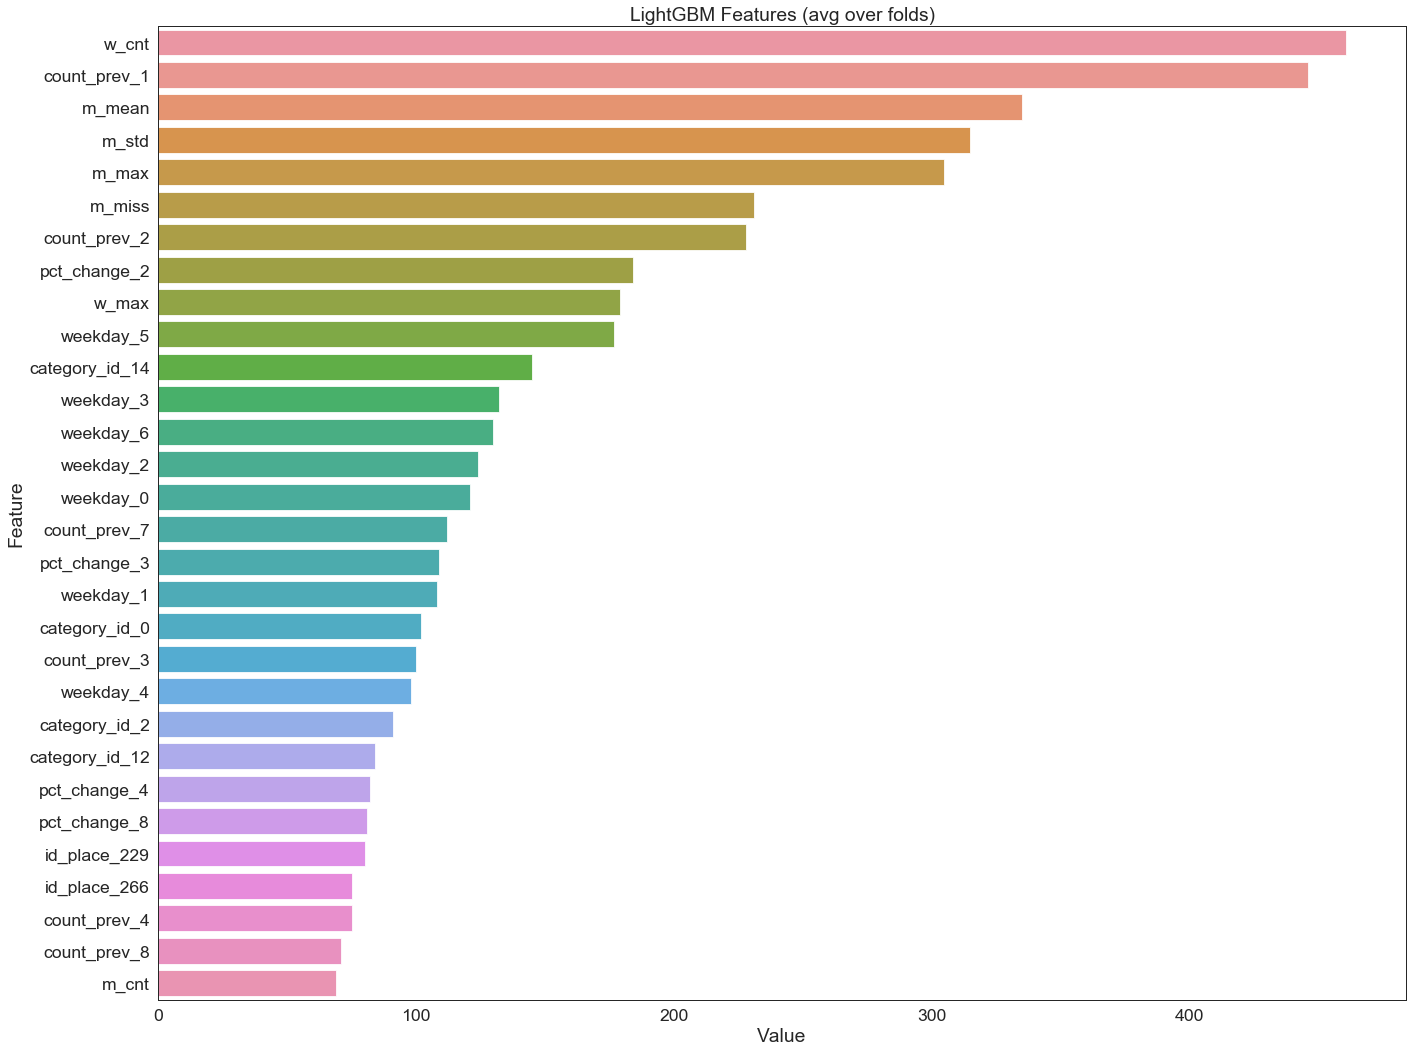

In [35]:
first = 30

sns.set_context("paper", font_scale=2)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),model.feature_name())), columns=['Value','Feature'])


#feature_imp = feature_imp[~(feature_imp.Feature.isin(['dev_max_turnover']))][:]

#feature_imp = feature_imp[int_columns][:]

feature_imp = feature_imp.tail(first)[:]

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
#plt.savefig('lgbm_importances-01.png')

In [36]:
cnt_predict = model.predict(X_test[interest_columns][:])

pred
real


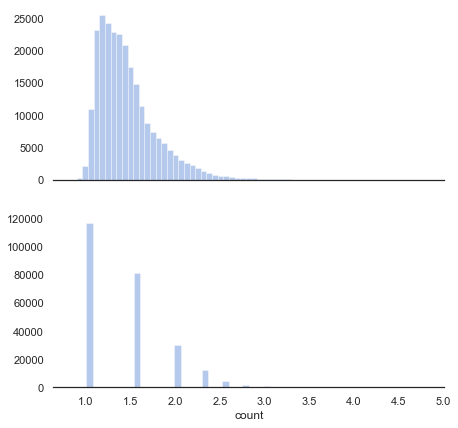

In [37]:
sns.set(style="white", palette="muted", color_codes=True)
rs = np.random.RandomState(10)

# Set up the matplotlib figure
f, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
sns.despine(left=True)

# Generate a random univariate dataset
d = rs.normal(size=100)

# Plot a simple histogram with binsize determined automatically
print('pred')
sns.distplot(cnt_predict, kde=False, color="b", ax=axes[0])

# Plot a simple histogram with binsize determined automatically
print('real')
sns.distplot(y_test, kde=False, color="b", ax=axes[1])


# predict future

In [39]:
test_df = pay_aggr_df[(pay_aggr_df['date'] >= test_date)][:]
test_df['pred'] = np.round(2 ** cnt_predict - 1,0)
test_df['amount'] = np.round(2 ** test_df['count'] - 1,0)

test_df['error'] = test_df['pred'] - test_df['amount'] 

In [49]:
test_df.groupby(['id_place' ,'id_good'])[['amount' , 'pred' ,'error']].sum().reset_index().sort_values(by = 'error' , ascending = False).head(10)


,id_place,id_good,amount,pred,error
19523,266,604,161.0,189.0,28.0
19467,266,347,288.0,306.0,18.0
7049,88,844,90.0,106.0,16.0
32391,393,374,64.0,79.0,15.0
19538,266,677,35.0,50.0,15.0
19475,266,379,13.0,28.0,15.0
19481,266,401,57.0,71.0,14.0
14095,163,374,76.0,90.0,14.0
19583,266,844,65.0,79.0,14.0
36098,431,374,80.0,94.0,14.0


In [50]:
id_place = 163
id_good = 374

df_plot = test_df[(test_df.id_place == id_place)
                 &(test_df.id_good == id_good)][:]


    

iplot([{"x": df_plot['date'], "y": df_plot['amount'] 
        , "name" :"real revenue" , "line_shape":'spline'}
      ,{"x": df_plot['date'], "y": df_plot['pred'] 
        , "name" :"pred revenue" , "line_shape":'spline'}
      ])

In [53]:
max_date = str(pay_aggr_df['date'].max())[:10]

date_past_2_weeks = str(datetime.datetime.strptime(max_date, '%Y-%m-%d') - datetime.timedelta(days=14))[:10]


df_pred_template = pay_aggr_df[(pay_aggr_df['date'] >= date_past_2_weeks)].groupby([ 'id_good' , 'category_id' , 'id_place'])[['count']].min().reset_index()
df_pred_template['count'] = np.nan


In [57]:
cnt_next_days = 7

for d in range(cnt_next_days):
    df_pred_step = df_pred_template[:]
    step_date = str(datetime.datetime.strptime(max_date, '%Y-%m-%d') + datetime.timedelta(days=1+d))[:10]
    df_pred_step['date'] = step_date
    df_pred_step['date'] = pd.to_datetime(df_pred_step['date'])
    
    frames = [pay_aggr_df[['date' ,'id_good' ,'category_id','id_place','count']], df_pred_step]
    pay_aggr_df = pd.concat(frames).reset_index(drop = True)
    pay_aggr_df['weekday'] = pay_aggr_df['date'].dt.weekday
    pay_aggr_df = make_dummies(pay_aggr_df = pay_aggr_df)
    pay_aggr_df = pay_aggr_df.sort_values(by = ['id_place','category_id','id_good','date'])[:]

    locs = pay_aggr_df[(pay_aggr_df['count'].isnull())].index
    
    pay_aggr_df , prev_columns , pct_change_columns , pct_rename = add_prev_days(pay_aggr_df = pay_aggr_df , want_days_back = want_days_back , merge_prev_df = merge_prev_df)
    pay_aggr_df , add_stats_columns = add_stats_info(pay_aggr_df = pay_aggr_df , want_days_back = want_days_back , prev_columns = prev_columns)
    pay_aggr_df = add_aditional(pay_aggr_df = pay_aggr_df , prev_columns = prev_columns , pct_change_columns = pct_change_columns , pct_rename = pct_rename)
    pay_aggr_df = clear_nulls(pay_aggr_df=pay_aggr_df)

    cnt_predict = model.predict(pay_aggr_df.loc[locs][interest_columns])
    
    time.sleep(3)
    
    if len(locs) > 0:
        pay_aggr_df.loc[locs , 'count'] = cnt_predict
        
    pay_aggr_df = pay_aggr_df[['date' ,'id_good' ,'category_id','id_place','count']][:]
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [58]:
pay_aggr_df.loc[: , 'count'] = 2 ** pay_aggr_df['count'] - 1
pay_aggr_df['count'] = pay_aggr_df['count'].round(0)

pay_aggr_df['count'] = pay_aggr_df['count'].astype(int)

In [64]:
id_place = 163
id_good = 374


pred_date = str(datetime.datetime.strptime(max_date, "%Y-%m-%d") - datetime.timedelta(days=14))[:10]

df_plot = pay_aggr_df[(pay_aggr_df['date'] > pred_date)][(pay_aggr_df.id_place == id_place)
                 &(pay_aggr_df.id_good == id_good)][:]


    

iplot([{"x": df_plot['date'], "y": df_plot['count'] 
        , "name" :"pred revenue" , "line_shape":'spline'}
       ,{"x": df_plot[df_plot['date'] < max_date]['date'], "y": df_plot[df_plot['date'] < max_date]['count'] 
        , "name" :"real revenue" , "line_shape":'spline'}
      ])


